In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import time

In [2]:
class Thermo_problem:
    def __init__(self, initial_f, left_f, right_f, f, D, x_range, t_range):
        self.initial_f = initial_f
        self.left_f = left_f
        self.right_f = right_f
        self.D = D
        self.x_range = x_range
        self.t_range = t_range
        self.f = f

In [3]:
def solve_diags_3(A, f):
    """Функция реализует метод прогонки СЛАУ.
    Принимает матрицу А левой части и вектор f правой части,
    необходимую точность. Возвращает вектор решения"""
    N = A.shape[0]
    d = f
    c = np.diagonal(A, offset=1)
    b = np.diagonal(A)
    a = np.diagonal(A, offset=-1)

    L = np.tril(A, k=-2)
    U = np.triu(A, k=2)
    if np.linalg.norm(L) > 0 or np.linalg.norm(U) > 0:
        print("Not 3x diagonal matrix!")
        return(-1)

    answer = [0] * N
    y = []
    y.append(b[0])
    alpha = []
    alpha.append(-c[0] / y[0])
    beta = []
    beta.append(d[0]/y[0])

    for i in range(1, N-1):
        y.append(b[i] + a[i-1] * alpha[-1])
        alpha.append(-c[i] / y[-1])
        beta.append((d[i] - a[i-1] * beta[-1]) / y[-1])
    y.append(b[N-1] + a[N-2] * alpha[-1])
    beta.append((d[N-1] - a[N-2] * beta[-1]) / y[-1])

    answer[-1] = beta[-1]
    for i in range(N-2, -1, -1):
        answer[i] = alpha[i] * answer[i+1] + beta[i]
    answer = np.array(answer)

    return(answer)

In [4]:
class Solve_Thermo:
    def __init__(self, problem):
        self.initial_f = problem.initial_f
        self.left_f = problem.left_f
        self.right_f = problem.right_f
        self.D = problem.D
        self.x_range = problem.x_range
        self.a = x_range[0]
        self.b = x_range[1]
        self.t_range = problem.t_range
        self.t0 = self.t_range[0]
        self.T = self.t_range[1]
        
    def solve_layer(self, prev_layer, n, grid, alpha, plot=False):
        N, M, h, tau, sigma = grid["N"], grid["M"], grid["h"], grid["tau"], grid["sigma"]
        x_arr = np.linspace(self.a, self.b, M+1)
        central_diag = np.array([1 + 2*sigma*alpha if m > 0 and m < M
                                else 1 for m in range(M+1)])
        lower_diag = np.array([ -sigma*alpha if m < M
                                else 0 for m in range(1, M+1)])
        upper_diag = np.array([ -sigma*alpha if m > 0 
                                else 0 for m in range(M)])
        matrix = np.diag(central_diag, k=0) + np.diag(lower_diag, k=-1) + np.diag(upper_diag, k=1)
        
        right_column = np.array([prev_layer[m] + sigma*(1-alpha)*
                                 (prev_layer[m+1] - 2*prev_layer[m] + prev_layer[m-1]) if m > 0 and m < M 
                                 else self.left_f((n+1)*tau) if m == 0 
                                 else self.right_f((n+1)*tau) for m in range(M+1)])
        right_column.transpose()
        
        next_layer = solve_diags_3(matrix, right_column)
        next_layer.transpose()
        
        return next_layer
    
    def solve(self, alpha, N, M, save_all = False, plot=True, delay=0.1):
        h = (self.b - self.a) / M
        tau = (self.T - self.t0) / N        
        sigma = tau * self.D / np.square(h)
        x_arr = np.linspace(self.a, self.b, M+1)
        grid = {"N": N, "M": M, "h": h, "tau": tau, "sigma": sigma}         
        layer = self.initial_f(x_arr)
        
        solution = []
        if save_all:
            solution.append(layer)
            
        if plot:
            plt.axis([0, 100, 0, 1])
            
            
        for n in range(N):
            layer = self.solve_layer(layer, n, grid, alpha=alpha)
            if save_all:
                solution.append(layer)
            if plot:
                plt.plot(x_arr, layer, linewidth=1)
                plt.pause(delay)
        
        if plot:
            plt.show
        
        return np.array(solution)
            

In [38]:
def initial_1(x):
    output = np.array([0 if element != 0 and element != 1 
                       else 50 if element == 0
                       else 100
                       for element in x])
    return output
def left_f_1(t):
    return 50
def right_f_1(t):
    return 100
def f_1(x, t):
    return 0
D = 0.2
x_range = (0, 1)
t_range = (0, 1)
problem_1 = Thermo_problem(initial_1, left_f_1, right_f_1, f_1, D, x_range, t_range)
solving = Solve_Thermo(problem_1)

In [39]:
N = 1000
M = 100
alpha = 1
solution = solving.solve(alpha, N, M, save_all=True, plot=False, delay=0.01)

Text(0.5, 0, 'U')

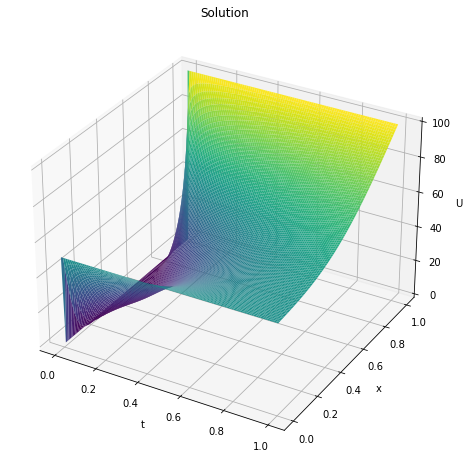

In [41]:
k = np.arange(0, M+1)
m = np.arange(0, M+1)
def arr_U(k, m):
    return solution[k*10, m]
fig = plt.figure(figsize = [8, 8])
ax = plt.axes(projection='3d')
X_0 = np.linspace(0, 1, M+1)
T_0 = np.linspace(0, 1, M+1)
X, T = np.meshgrid(X_0, T_0)
k, m = np.meshgrid(k, m)
data_plot = arr_U(k, m)

ax.plot_surface(X, T, data_plot, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Solution')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('U')